# Customer Churn Prediction

In [1]:
# Importing required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mean
import warnings

from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay,precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier


warnings.filterwarnings("ignore")
%matplotlib inline

### Read data

In [2]:
# load xlsx file

df = pd.read_excel("customer_churn_large_dataset.xlsx")

In [3]:
df.head()

,CustomerID,Name,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,1,Customer_1,63,Male,Los Angeles,17,73.36,236,0
1,2,Customer_2,62,Female,New York,1,48.76,172,0
2,3,Customer_3,24,Female,Los Angeles,5,85.47,460,0
3,4,Customer_4,36,Female,Miami,3,97.94,297,1
4,5,Customer_5,46,Female,Miami,19,58.14,266,0


In [4]:
# checking rows and columns for the dataset

df.shape


(100000, 9)

In [5]:
# columns datatypes
df.columns

Index(['CustomerID', 'Name', 'Age', 'Gender', 'Location',
       'Subscription_Length_Months', 'Monthly_Bill', 'Total_Usage_GB',
       'Churn'],
      dtype='object')

### Observations :-
- Here "CustomerID" and "Name" features are not required for our analysis,so remove these two columns

In [6]:
# Dropping "CustomerID" and "Name" columns

df.drop(["CustomerID","Name"],axis = 1,inplace = True)

In [7]:
# DataFrame after removing above two columns
df.head(2)

,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,63,Male,Los Angeles,17,73.36,236,0
1,62,Female,New York,1,48.76,172,0


In [8]:
# defining numerical & categorical columns

numerical_features = [feature for feature in df.columns if df[feature].dtype !="O"]
categorical_features = [feature for feature in df.columns if df[feature].dtype =="O"]

# Printing numerical and categorical features
print('We have {} numerical features : {}'.format(len(numerical_features), numerical_features))
print('\nWe have {} categorical features : {}'.format(len(categorical_features), categorical_features))

We have 5 numerical features : ['Age', 'Subscription_Length_Months', 'Monthly_Bill', 'Total_Usage_GB', 'Churn']

We have 2 categorical features : ['Gender', 'Location']


### *Checking missing values in the DataFrame


In [9]:
df.isna().sum()

Age                           0
Gender                        0
Location                      0
Subscription_Length_Months    0
Monthly_Bill                  0
Total_Usage_GB                0
Churn                         0
dtype: int64

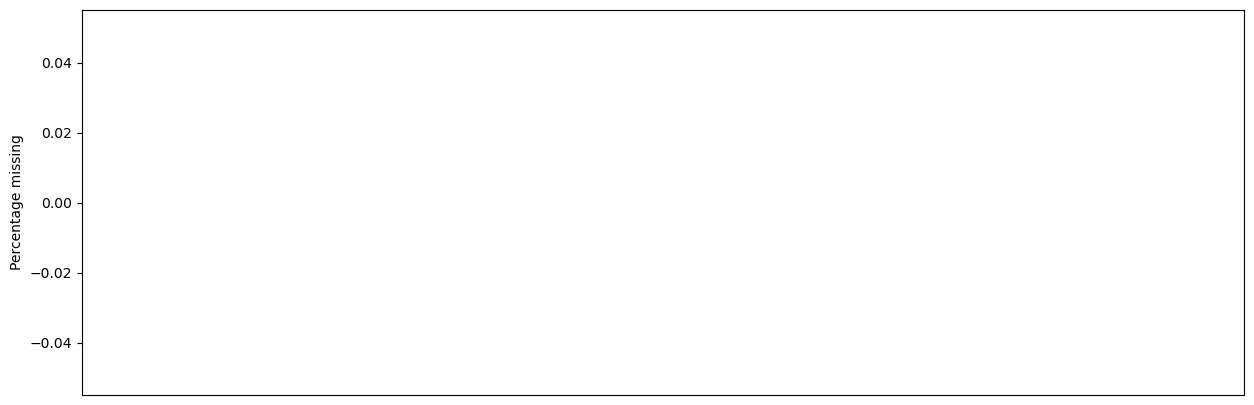

In [10]:
# Plotting Missing values count for each column
fig, ax = plt.subplots(figsize=(15,5))

missing = df.isna().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0, ascending = False)

ax.bar(missing.index, missing.values.T[0])
plt.xticks([])
plt.ylabel("Percentage missing")
plt.show()

### Observations :- 
- There are no missing values in any column ,so no need to perform any imputation operations
- Graph showing empty as there are no missing values

### *Checking duplicate values

In [11]:
df.duplicated().sum()

0

### Observations :- 
- There are no duplicate values

### *Checking for outliers in the DataFrame

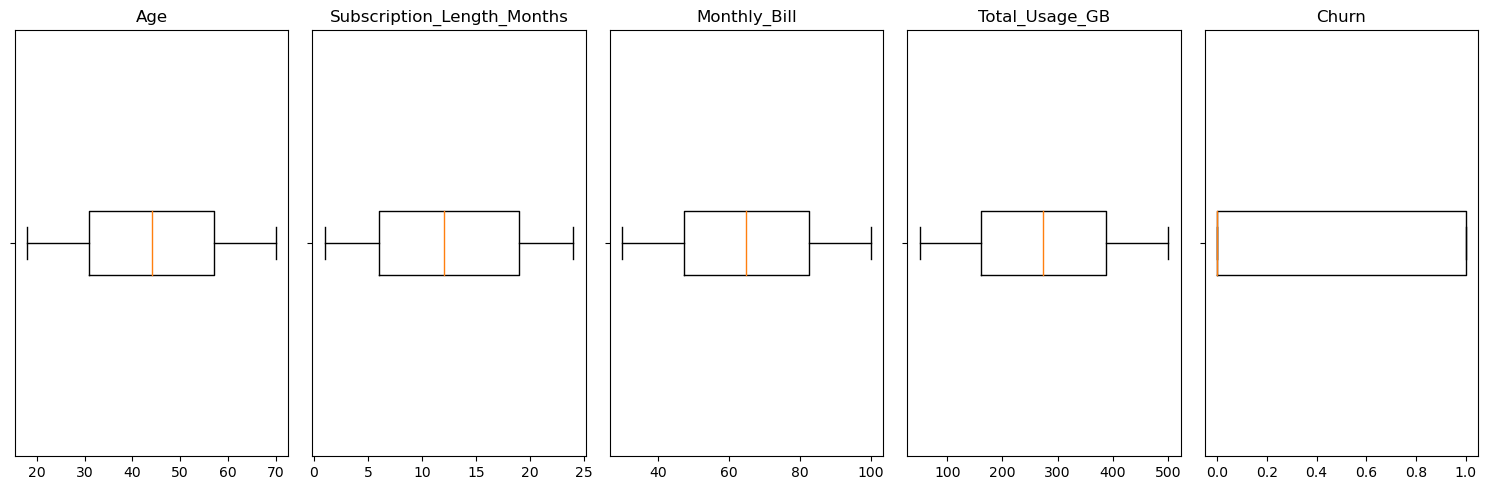

In [12]:
# Create a figure with subplots
fig, axes = plt.subplots(1, len(numerical_features), figsize=(15, 5)) 

# Plot boxplots for each column in a subplot
for i, column in enumerate(numerical_features):
    axes[i].boxplot(df[column], vert=False)
    axes[i].set_title(column)
    axes[i].set_yticklabels([]) 

plt.tight_layout()
plt.show()



### Observations :- 

- By above graph we can say there are no outliers

### *Checking the whether the dataset is imbalanced or not

In [13]:
df['Churn'].value_counts()

0    50221
1    49779
Name: Churn, dtype: int64

### Visualization of unique values in Target Variable

Positive: 49779, Negative: 50221


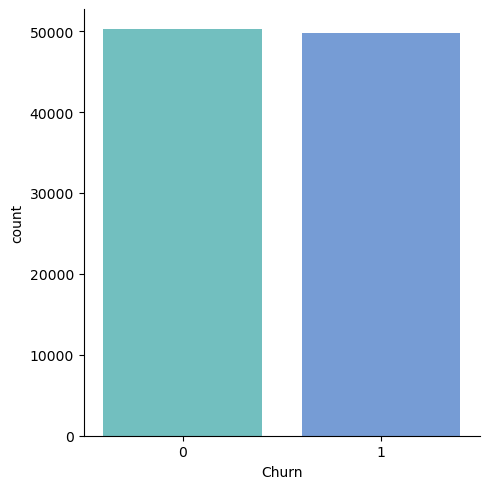

In [14]:
pos = df[df['Churn']==1].shape[0]
neg = df[df['Churn']==0].shape[0]
print("Positive: " + str(pos) + ", Negative: " + str(neg))
sns.catplot(data=df, x="Churn", kind="count", palette="winter_r", alpha=.6)
plt.show()

### Observations :- 

- The dataset is balanced
- No need to perform resampling

### *Checking correlation

<Axes: >

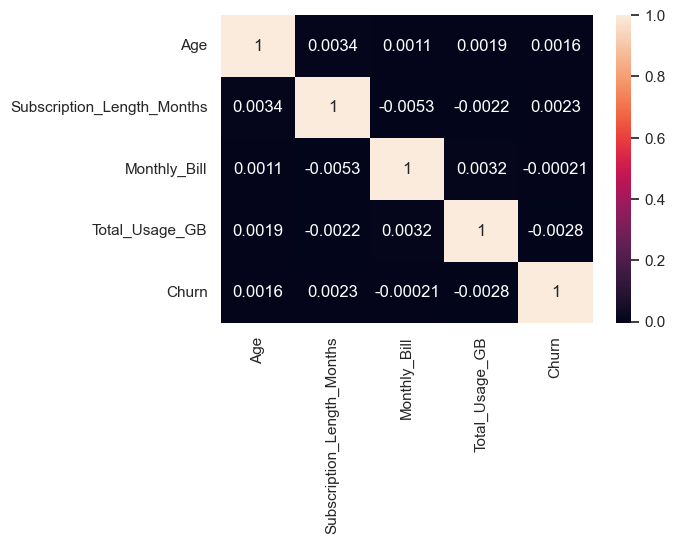

In [15]:
sns.set(rc ={'figure.figsize':(6,4) })
sns.heatmap(df.corr(),annot = True)

### Observations :- 

- There is no correlation among the features

### * Checking skewness

In [16]:
df.skew()

Age                          -0.002689
Subscription_Length_Months   -0.001655
Monthly_Bill                 -0.000326
Total_Usage_GB                0.007113
Churn                         0.008840
dtype: float64

### Observations :- 

- The features are not skewed

### Plotting Distribution of all Independent Numerical features

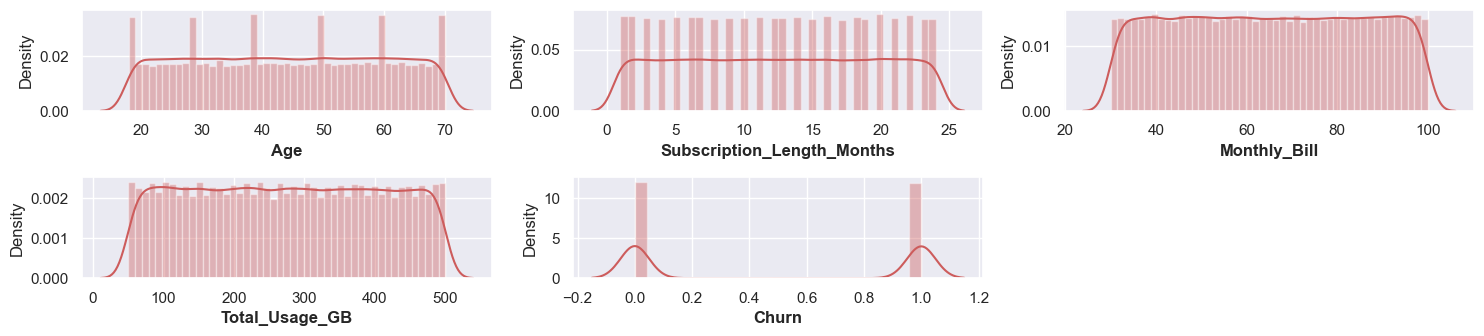

In [17]:
plt.figure(figsize=(15, 100))
for i, col in enumerate(numerical_features):
    plt.subplot(60, 3, i+1)
    sns.distplot(x=df[col], color='indianred')
    plt.xlabel(col, weight='bold')
    plt.tight_layout()

### Observations :- 

- features are following uniform distribution

### Performing feature transformation
- Here we have two categorical features we need to convert them into numerical values
- Both the features are nominal variables we can use get_dummies method

In [18]:
df['Location'].unique()

array(['Los Angeles', 'New York', 'Miami', 'Chicago', 'Houston'],
      dtype=object)

In [19]:
df['Gender'].unique()

array(['Male', 'Female'], dtype=object)

In [20]:
dummies = pd.get_dummies(df['Location'])
dummies

,Chicago,Houston,Los Angeles,Miami,New York
0,0,0,1,0,0
1,0,0,0,0,1
2,0,0,1,0,0
3,0,0,0,1,0
4,0,0,0,1,0
...,...,...,...,...,...
99995,0,1,0,0,0
99996,0,0,0,0,1
99997,1,0,0,0,0
99998,0,0,0,0,1


In [21]:
# now combining two dataframes
df = pd.concat([df,dummies],axis = 1)

In [22]:
df.head(2)

,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn,Chicago,Houston,Los Angeles,Miami,New York
0,63,Male,Los Angeles,17,73.36,236,0,0,0,1,0,0
1,62,Female,New York,1,48.76,172,0,0,0,0,0,1


In [23]:
# Dropping Location column as we created dummies for it
df.drop("Location",axis = 1,inplace = True)

In [24]:
dummies = pd.get_dummies(df["Gender"])
dummies.head()

,Female,Male
0,0,1
1,1,0
2,1,0
3,1,0
4,1,0


In [25]:
# now combining two dataframes
df = pd.concat([df,dummies],axis = 1)

In [26]:
# Dropping Location column as we created dummies for it
df.drop("Gender",axis = 1,inplace = True)

In [27]:
df.head(2)

,Age,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn,Chicago,Houston,Los Angeles,Miami,New York,Female,Male
0,63,17,73.36,236,0,0,0,1,0,0,0,1
1,62,1,48.76,172,0,0,0,0,0,1,1,0


### Functions for model training and evaluation

In [28]:
def evaluate_clf(true, predicted):
    '''
    This function takes in true values and predicted values
    Returns: Accuracy, F1-Score, Precision, Recall, Roc-auc Score
    '''
    acc = accuracy_score(true, predicted) # Calculate Accuracy
    f1 = f1_score(true, predicted) # Calculate F1-score
    precision = precision_score(true, predicted) # Calculate Precision
    recall = recall_score(true, predicted)  # Calculate Recall
    roc_auc = roc_auc_score(true, predicted) #Calculate Roc
    return acc, f1 , precision, recall, roc_auc

In [29]:
# Create a function which can evaluate models and return a report 
def evaluate_models(X, y, models):
    '''
    This function takes in X and y and models dictionary as input
    It splits the data into Train Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: Dataframe which contains report of all models metrics with cost
    '''
    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
    
    models_list = []
    train_accuracy_list = []
    test_accuracy_list = []
    train_precision_list = []
    test_precision_list = []
    train_recall_list = []
    test_recall_list = []
    train_f1_score = []
    test_f1_score = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model

        # Make predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Training set performance
        model_train_accuracy, model_train_f1,model_train_precision,\
        model_train_recall,model_train_rocauc_score=evaluate_clf(y_train ,y_train_pred)
        

        # Test set performance
        model_test_accuracy,model_test_f1,model_test_precision,\
        model_test_recall,model_test_rocauc_score=evaluate_clf(y_test, y_test_pred)
        
        train_accuracy_list.append(model_train_accuracy)
        test_accuracy_list.append(model_test_accuracy)
        train_precision_list.append(model_train_precision)
        test_precision_list.append(model_test_precision)
        train_recall_list.append(model_train_recall)
        test_recall_list.append(model_test_recall)
        train_f1_score.append(model_train_f1)
        test_f1_score.append(model_test_f1)
        
        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])

        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(model_train_accuracy))
        print('- F1 score: {:.4f}'.format(model_train_f1)) 
        print('- Precision: {:.4f}'.format(model_train_precision))
        print('- Recall: {:.4f}'.format(model_train_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(model_test_accuracy))
        print('- F1 score: {:.4f}'.format(model_test_f1))
        print('- Precision: {:.4f}'.format(model_test_precision))
        print('- Recall: {:.4f}'.format(model_test_recall))
        print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))
        print('='*35)
        print('\n')
        
    report=pd.DataFrame(list(zip(models_list, train_accuracy_list,test_accuracy_list,train_precision_list,test_precision_list,train_recall_list,test_recall_list,train_f1_score,test_f1_score)), columns=['Model Name', 'Train Accuracy',"Test Accuracy","Train Precision","Test Precision","Train Recall","Test Recall","Train f1_score","Test f1_score"]).sort_values(by=["Train f1_score"])
    
    return report

In [30]:
# Splitting X and y

X = df.drop('Churn',axis = 1)
y = df["Churn"]

In [31]:
# Initializing different models in a dictionary

models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(), 
    "AdaBoost Classifier": AdaBoostClassifier()
}

In [96]:
report  = evaluate_models(X,y,models)

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.4940
- F1 score: 0.4807
- Precision: 0.4896
- Recall: 0.4722
- Roc Auc Score: 0.4938


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.5027
- F1 score: 0.4995
- Precision: 0.4987
- Recall: 0.5004
- Roc Auc Score: 0.5027


Gradient Boosting
Model performance for Training set
- Accuracy: 0.5391
- F1 score: 0.5136
- Precision: 0.5415
- Recall: 0.4885
- Roc Auc Score: 0.5389
----------------------------------
Model performance for Test set
- Accuracy: 0.4993
- F1 score: 0.4713
- Precision: 0.4948
- Recall: 0.4500
- Roc Auc Score: 0.4989


Logistic Regression
Model performance for Training 

In [97]:
report

,Model Name,Train Accuracy,Test Accuracy,Train Precision,Test Precision,Train Recall,Test Recall,Train f1_score,Test f1_score
3,Logistic Regression,0.502525,0.49990,0.501272,0.493155,0.296528,0.294124,0.372628,0.368481
6,AdaBoost Classifier,0.515675,0.50355,0.515641,0.499550,0.459883,0.447132,0.486168,0.471890
2,Gradient Boosting,0.539088,0.49930,0.541508,0.494845,0.488509,0.449955,0.513645,0.471334
5,XGBClassifier,0.653663,0.49875,0.654369,0.494695,0.646144,0.488761,0.650230,0.491710
4,K-Neighbors Classifier,0.688150,0.49645,0.688801,0.492341,0.682372,0.485939,0.685572,0.489119
0,Random Forest,1.000000,0.49395,1.000000,0.489551,1.000000,0.472231,1.000000,0.480735
1,Decision Tree,1.000000,0.50270,1.000000,0.498744,1.000000,0.500353,1.000000,0.499547


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [43]:
dt = DecisionTreeClassifier()

### Hyperparameter tuning

In [44]:
grid_param = {
    "criterion":['gini','entropy'],
    'max_depth':range(2,32,1),
    'min_samples_leaf':range(1,10,1),
    'min_samples_split':range(2,10,1),
    'splitter':['best','random']
}

In [45]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator=dt,param_grid=grid_param,cv = 5)

In [46]:
grid_search.fit(X_train,y_train)

KeyboardInterrupt: 

In [ ]:
grid_search.best_params_